In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import cython
import numba
from numba import jit, njit, prange
import time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [3]:
#import xlsx
df = pd.read_excel('scraper_latest/data/foxnews.xlsx')

In [4]:
df.head()

,Unnamed: 0,publish_date,headline,main_text,media,type,url
0,0,"April 27, 2012 7:36am EDT","Maingear Annouces 11-inch Gaming Notebook, Fil...","Poor Alienware M11x, we hardly knew ye. After ...",FoxNews,article,https://www.foxnews.com/tech/maingear-annouces...
1,1,"October 6, 2015 9:26am EDT","Microsoft Debuts Surface Book, a 13-Inch Laptop","Microsoft today debuted the Surface Book, a 13...",FoxNews,article,https://www.foxnews.com/tech/microsoft-debuts-...
2,2,"September 6, 2012 9:32am EDT","Amazon Launches Kindle Fire HD: 8.9-inch, 1920...",Amazon is going big with the Kindle Fire HD. T...,FoxNews,article,https://www.foxnews.com/tech/amazon-launches-k...
3,3,"June 5, 2012 3:21am EDT",Nvidia GeForce GTX 680M GPU Adds Keplar Streng...,"Today Nvidia announced the GeForce GTX 680M, a...",FoxNews,article,https://www.foxnews.com/tech/nvidia-geforce-gt...
4,4,"December 18, 2023 2:00pm EST",Why does Washington want to kill off America's...,Nothing exemplifies America's tech industry do...,FoxNews,article,https://www.foxnews.com/opinion/why-does-washi...


In [5]:
# convert main_text into tokens, [['token','token',...],['token','token',...],['token','token',...]], with the parameter to adapt to bigram, trigram, etc.
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.util import ngrams
import re
from nltk.stem import WordNetLemmatizer


def clean_text(text, ngram = 1):
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # remove url
    text = re.sub(r'http\S+', '', text)
    # remove digits
    text = re.sub(r'\d+', '', text)
    # remove stopwords
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    # remove single characters
    text = re.sub(r'\b\w\b', '', text)
    # remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # lowercase
    text = text.lower()
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    # tokenize
    tokens = word_tokenize(text)
    for i in range(2, ngram+1):
        tokens.extend([' '.join(gram) for gram in ngrams(text.split(), i)])
    return tokens

In [6]:
df['text'] = df['main_text'].apply(lambda x: clean_text(x, ngram = 1))

In [7]:
df['text'][0]

['poor',
 'alienware',
 'mx',
 'hardly',
 'knew',
 'ye',
 'two',
 'year',
 'alienware',
 'officially',
 'discontinued',
 'alienware',
 'mx',
 'gaming',
 'laptop',
 'earlier',
 'month',
 'however',
 'news',
 'maingear',
 'announced',
 'inch',
 'gaming',
 'notebook',
 'according',
 'engadget',
 'inch',
 'maingear',
 'pulse',
 'intriguing',
 'spec',
 'ivy',
 'bridge',
 'processor',
 'nvidia',
 'geforce',
 'gtm',
 'gb',
 'vram',
 'intel',
 'gma',
 'hd',
 'gpu',
 'petite',
 'hood',
 'spec',
 'include',
 'ledbacklit',
 'display',
 'usb',
 'hdmi',
 'gb',
 'hdd',
 'gb',
 'ram',
 'expect',
 'shell',
 'least',
 'core',
 'starting',
 'configuration',
 'still',
 'remains',
 'seen',
 'gamers',
 'clamoring',
 'serious',
 'gaming',
 'rig',
 'inch',
 'form',
 'factor',
 'maingear',
 'case',
 'june',
 'first',
 'model',
 'begin',
 'shipping']

In [8]:
# #split df['text']
# from sklearn.model_selection import train_test_split
# X = df['text']
# X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [8]:
# Splitted functions version in order for optimization
import numpy as np
from numba import jit, types

# use a dictionary to simulate the class self.properties, the dictionary is the model
def initialize_lda(K, alpha, beta, num_iterations):
    lda = {
        "K": K,
        "alpha": alpha,
        "theta": None,
        "beta": beta,
        "phi": None,
        "num_iterations": num_iterations,
        "vocabulary": None
    }
    return lda

def build_vocabulary(documents):
    return list(set([word for doc in documents for word in doc]))

# Numba is having trouble compiling the code due to the presence of 
# reflected containers (lists of lists) with Unicode elements.
# So here convert to simper arrays
# looks a bit awkward, other better options?
def encode_documents(documents, vocabulary):
    #vocabulary = list(set([word for doc in documents for word in doc]))
    word_to_index = {word: idx for idx, word in enumerate(vocabulary)}
    encoded_documents = []
    for doc in documents:
        encoded_doc = [word_to_index[word] for word in doc if word in word_to_index]
        encoded_documents.append(np.array(encoded_doc, dtype=np.int32))
    return encoded_documents

@jit(nopython=True)
def initialize_count_matrices(K, D, V, encoded_documents):
    n_k_i = np.zeros((K, V), dtype=np.int32)
    n_k = np.zeros(K, dtype=np.int32)
    n_j_k = np.zeros((D, K), dtype=np.int32)
    n_j = np.zeros(D, dtype=np.int32)
    
    topic_assignments = []
    for doc in encoded_documents:
        doc_topic_assignments = np.random.randint(0, K, size=len(doc))#.astype(np.int32)
        topic_assignments.append(doc_topic_assignments)
    
    for d, doc in enumerate(encoded_documents):
        for i, word_idx in enumerate(doc):
            topic = topic_assignments[d][i]
            n_k_i[topic, word_idx] += 1
            n_k[topic] += 1
            n_j_k[d, topic] += 1
            n_j[d] += 1
    
    return n_k_i, n_k, n_j_k, n_j, topic_assignments

@jit(nopython=True)
def gibbs_sampling(num_iterations, encoded_documents, n_k_i, n_k, n_j_k, n_j, topic_assignments, K, alpha, beta, V):
    for _ in range(num_iterations):
        for d, doc in enumerate(encoded_documents):
            for i, word_idx in enumerate(doc):
                topic = topic_assignments[d][i]
                
                n_k_i[topic, word_idx] -= 1
                n_k[topic] -= 1
                n_j_k[d, topic] -= 1
                n_j[d] -= 1
                
                p_topic = (n_k_i[:, word_idx] + beta) / (n_k + V * beta) * (n_j_k[d] + alpha) / (n_j[d] + K * alpha)
                p_topic /= np.sum(p_topic)
                
                new_topic = np.random.multinomial(1, p_topic).argmax()
                
                n_k_i[new_topic, word_idx] += 1
                n_k[new_topic] += 1
                n_j_k[d, new_topic] += 1
                n_j[d] += 1
                
                topic_assignments[d][i] = new_topic
    
    return n_k_i, n_k, n_j_k, n_j, topic_assignments

def estimate_parameters(lda, n_k_i, n_k, n_j_k, n_j):
    lda["theta"] = (n_j_k + lda["alpha"]) / (n_j[:, np.newaxis] + lda["K"] * lda["alpha"])
    lda["phi"] = (n_k_i + lda["beta"]) / (n_k[:, np.newaxis] + len(lda["vocabulary"]) * lda["beta"])

def fit_lda(lda, documents):
    lda["vocabulary"] = build_vocabulary(documents)
    encoded_documents = encode_documents(documents, lda["vocabulary"])
    n_k_i, n_k, n_j_k, n_j, topic_assignments = initialize_count_matrices(lda["K"], len(encoded_documents), len(lda["vocabulary"]), encoded_documents)
    n_k_i, n_k, n_j_k, n_j, topic_assignments = gibbs_sampling(lda["num_iterations"], encoded_documents, n_k_i, n_k, n_j_k, n_j, topic_assignments, lda["K"], lda["alpha"], lda["beta"], len(lda["vocabulary"]))
    estimate_parameters(lda, n_k_i, n_k, n_j_k, n_j)

@jit(nopython=True)
def transform_lda_helper(theta, encoded_documents, phi, alpha, K):
    for d, doc in enumerate(encoded_documents):
        topic_counts = np.zeros(K, dtype=np.int32)
        for word_idx in doc:
            topic_probs = phi[:, word_idx]
            topic_probs /= np.sum(topic_probs)
            topic = np.random.multinomial(1, topic_probs).argmax()
            topic_counts[topic] += 1
        theta[d] = (topic_counts + alpha) / (len(doc) + K * alpha)
    return theta

def transform_lda(lda, documents):
    encoded_documents = encode_documents(documents, lda["vocabulary"])
    D = len(encoded_documents)
    theta = np.zeros((D, lda["K"]))
    theta = transform_lda_helper(theta, encoded_documents, lda["phi"], lda["alpha"], lda["K"])
    return theta

def get_topics(lda, top_words=10):
    for topic_idx in range(lda["K"]):
        print(f"Topic {topic_idx+1}:")
        word_probs = lda["phi"][topic_idx]
        top_word_indices = word_probs.argsort()[-top_words:][::-1]
        top_words_list = [lda["vocabulary"][idx] for idx in top_word_indices]
        print(f"  Top words: {', '.join(top_words_list)}\n")


In [10]:
K = 4
alpha = 0.1
beta = 0.01
num_iterations = 5000

st = time.time()
lda = initialize_lda(K, alpha, beta, num_iterations)
X = df['text']
fit_lda(lda, X)
get_topics(lda)
et = time.time()
print("Time used:", et - st)

Topic 1:
  Top words: inch, gb, graphic, display, gaming, processor, notebook, new, core, available

Topic 2:
  Top words: game, nvidia, tablet, device, screen, like, tegra, card, amd, google

Topic 3:
  Top words: new, graphic, said, made, news, people, stock, world, pelosi, company

Topic 4:
  Top words: million, share, cent, said, company, year, inc, percent, revenue, corp

Time used: 38.26477789878845


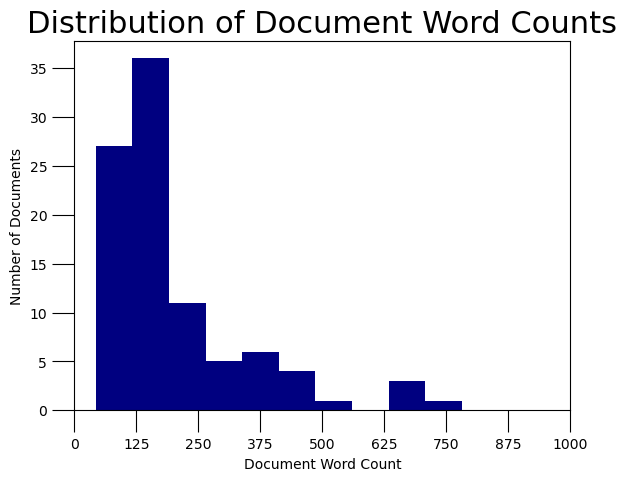

In [ ]:
doc_lens = [len(d) for d in df['text']]

plt.hist(doc_lens, color='navy')

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [11]:
lda['theta'].shape

(94, 4)

In [12]:
# create a dataframe with rows being vocabulary and columns being topics
df_phi = pd.DataFrame(lda['phi'], columns=lda['vocabulary']).T
df_phi.head()

,0,1,2,3
period,0.000002,0.000001,0.000003,0.009283
magnet,0.000182,0.000001,0.000003,0.000003
cited,0.000002,0.000001,0.000305,0.000003
glare,0.000002,0.000142,0.000003,0.000003
cathy,0.000002,0.000001,0.000305,0.000003


In [13]:
# create a train dataframe with rows being documents and columns being topics
df_theta = pd.DataFrame(lda['theta'])

# add a column of topic assigned
topic_assinged = lda['theta'].argmax(axis=1)
df_theta['topic'] = topic_assinged

# add a column of main_text
df_theta['main_text_tokenized'] = X.reset_index(drop=True)
df_theta.head()

,0,1,2,3,topic,main_text_tokenized
0,0.782116,0.127204,0.089421,0.001259,0,"[poor, alienware, mx, hardly, knew, ye, two, y..."
1,0.526573,0.309653,0.125271,0.038503,0,"[microsoft, today, debuted, surface, book, inc..."
2,0.480815,0.468825,0.001199,0.049161,0,"[amazon, going, big, kindle, fire, hd, inch, t..."
3,0.711255,0.286900,0.000923,0.000923,0,"[today, nvidia, announced, geforce, gtx, versi..."
4,0.108353,0.233937,0.511390,0.146320,2,"[nothing, exemplifies, america, tech, industry..."


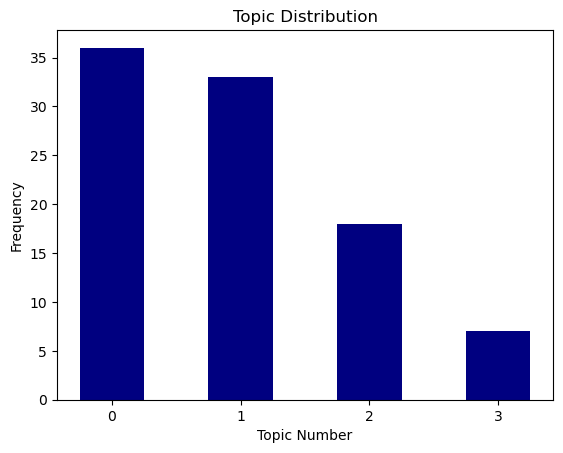

In [26]:
# Assuming df['topic'] contains the topic numbers
topic_counts = df_theta['topic'].value_counts()

# Sort the topic counts by index (topic number)
topic_counts = topic_counts.sort_index()

# Plotting the histogram
plt.bar(topic_counts.index, topic_counts.values, width=0.5, color='navy')

# Labeling the axes and title
plt.xlabel('Topic Number')
plt.ylabel('Frequency')
plt.title('Topic Distribution')

# Set the x-axis tick marks to show only integers
plt.xticks(range(len(topic_counts.index)), topic_counts.index)

# Show the plot
plt.show()


In [42]:
# # create a test dataframe with rows being documents and columns being topics
# df_theta_test = pd.DataFrame(theta)

# # add a column of topic assigned
# topic_assinged = theta.argmax(axis=1)
# df_theta_test['topic'] = topic_assinged

# # add a column of main_text
# df_theta_test['main_text_tokenized'] = X_test.reset_index(drop=True)
# df_theta_test.head()

,0,1,2,3,topic,main_text_tokenized
0,0.109813,0.070872,0.608255,0.211059,2,"[proving, slim, mean, underpowered, asus, toda..."
1,0.053792,0.080247,0.397707,0.468254,3,"[year, computex, trade, show, taipei, amidst, ..."
2,0.153113,0.089581,0.286531,0.470775,3,"[nintendo, switch, available, buy, little, yea..."
3,0.018836,0.104452,0.686644,0.190068,2,"[freshly, minted, macbook, pro, town, announce..."
4,0.072443,0.086648,0.740057,0.100852,2,"[poor, alienware, mx, hardly, knew, ye, two, y..."


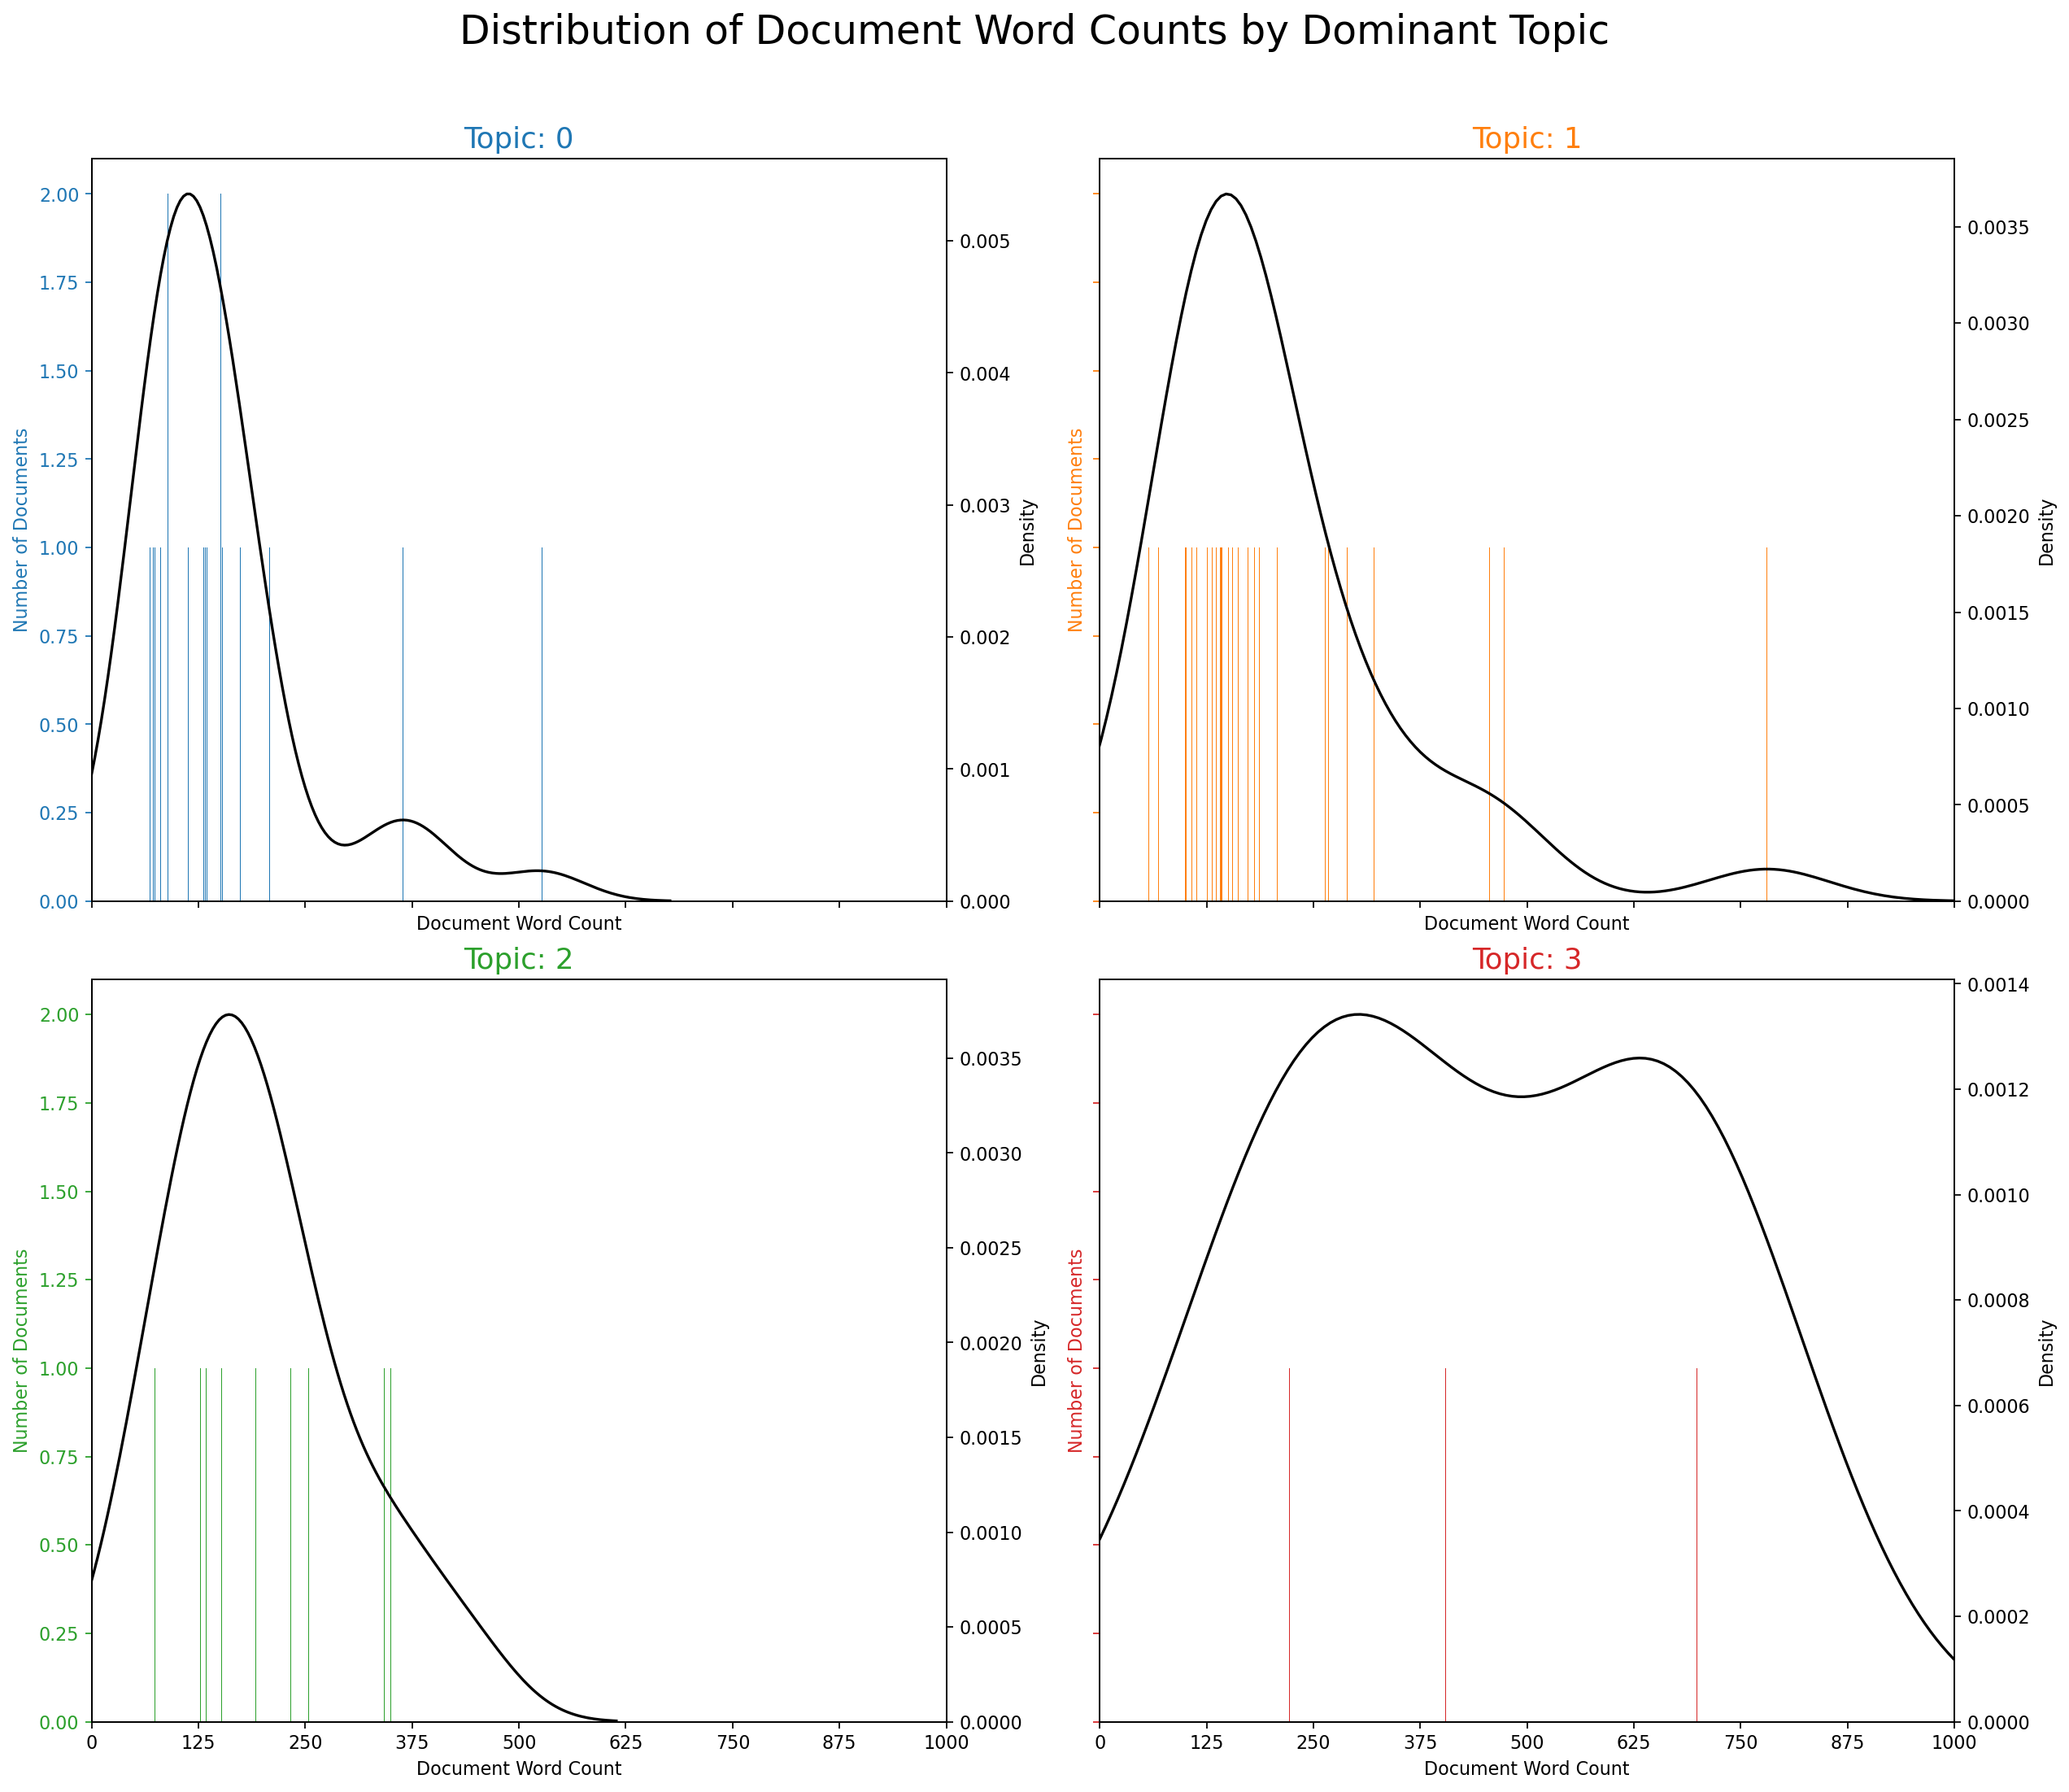

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Sample DataFrame lda_df
# lda_df = ...

# Sample data
# Assuming lda_df has columns [0, 1, 2, 3, 'topic', 'main_text_tokenized']

# Generate colors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_theta.loc[df_theta['topic'] == i, :]
    doc_lens = [len(tokens) for tokens in df_dominant_topic_sub['main_text_tokenized']]
    ax.hist(doc_lens, bins=1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: ' + str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0, 1000, 9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

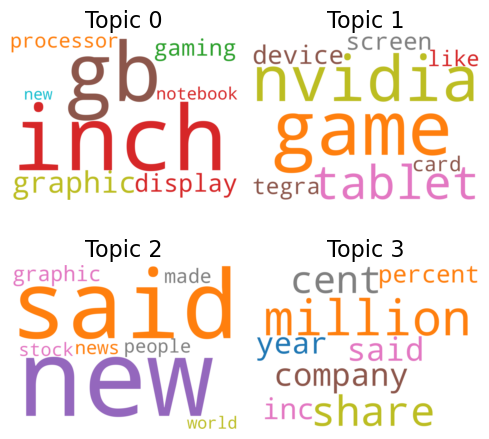

In [28]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Sample DataFrame df_topics
# df_topics = ...

# Generate colors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create a WordCloud object
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=8,
                  colormap='tab10',
                  prefer_horizontal=1.0)

# Assuming lda_model.show_topics(formatted=False) returns a list of topics
topics = ["Topic {}".format(i) for i in range(len(df_phi.columns))]  # Create topics list

fig, axes = plt.subplots(2, 2, figsize=(5, 5), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    topic_words = dict(df_phi.iloc[:, i])  # Extract topic words from DataFrame
    cloud.generate_from_frequencies(topic_words)
    ax.imshow(cloud, interpolation='bilinear')
    ax.set_title(topics[i], fontdict=dict(size=16))
    ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


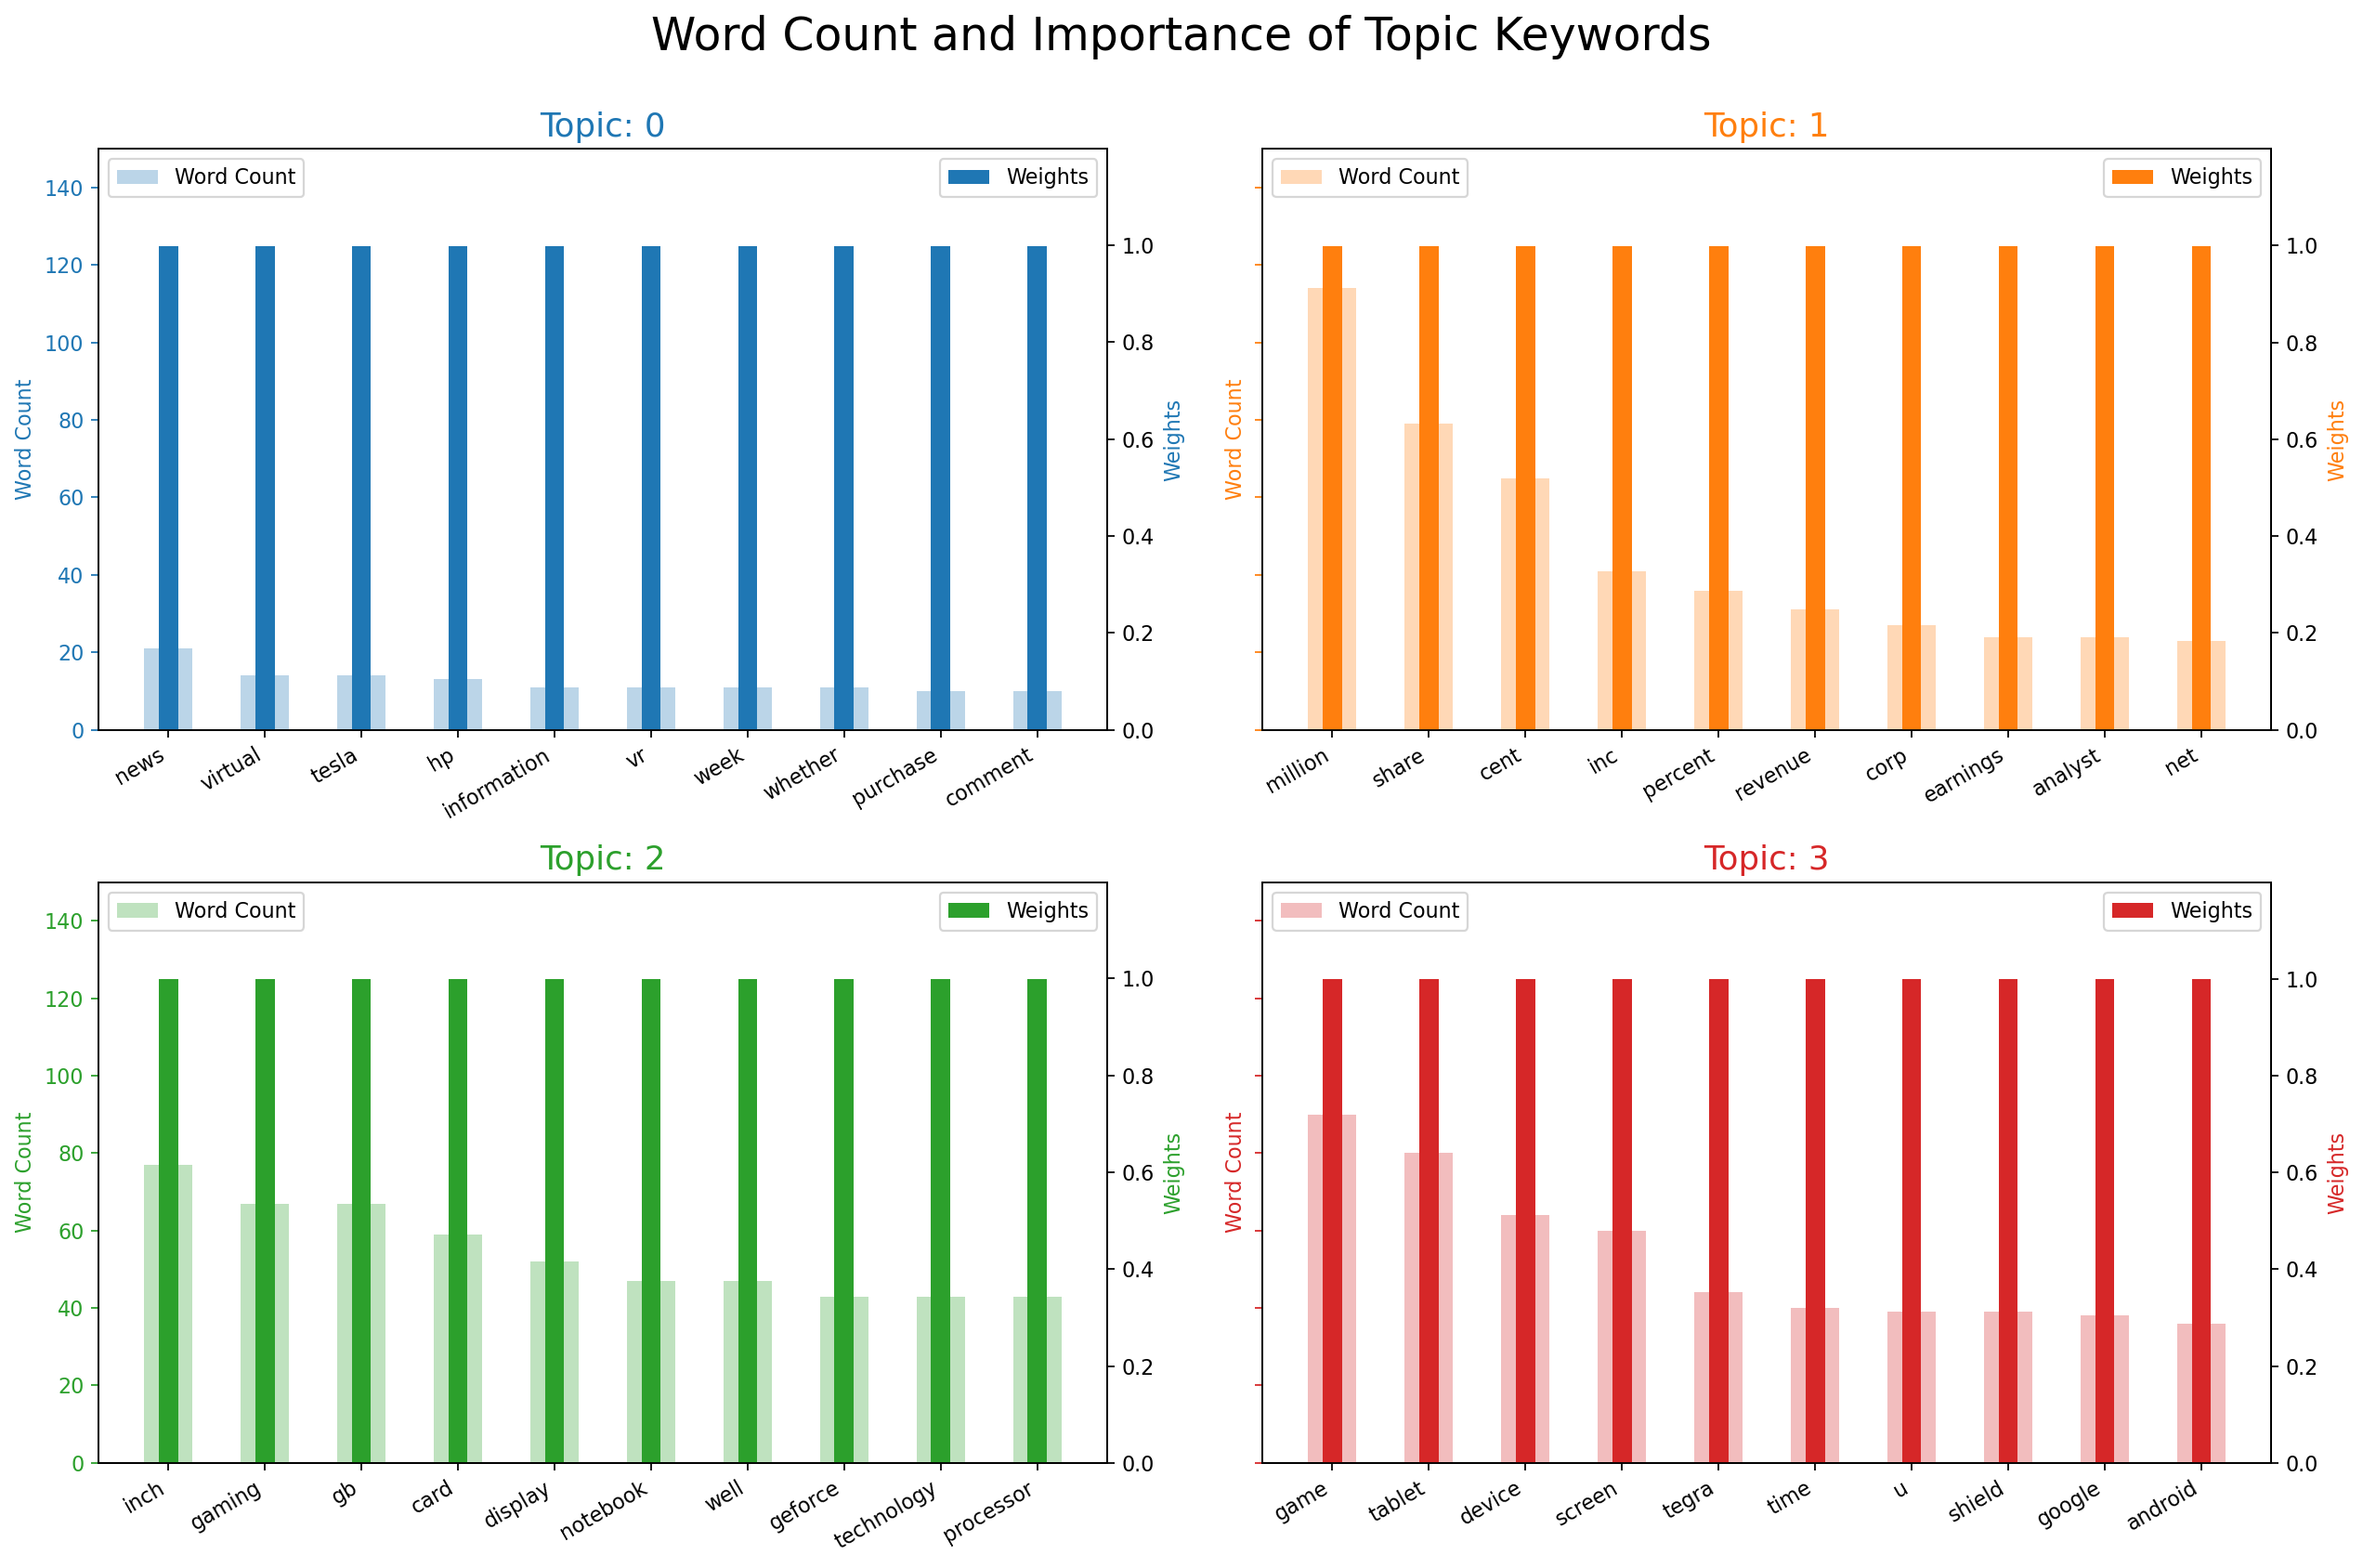

In [66]:
from collections import Counter

# Sample DataFrames df_phi and df_theta
# df_phi = ...
# df_theta = ...

# Extract topic words from df_phi
topics = df_phi.columns

# Flatten the tokenized text in df_theta
data_flat = [word for sublist in df_theta['main_text_tokenized'] for word in sublist]

# Count the occurrence of each word in the corpus
counter = Counter(data_flat)

out = []

# Iterate over topics
for i, topic in enumerate(topics):
    # Iterate over vocabularies and probabilities in the topic
    for word, prob in df_phi[[topic]].iterrows():
        # Append word, topic id, importance (probability), and word count to the out list
        out.append([word, topic, prob.values[0], counter[word]])

# Create DataFrame from out list
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Sort DataFrame by importance within each topic
df_sorted = df.groupby('topic_id').apply(lambda x: x.nlargest(10, 'importance')).reset_index(drop=True)

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    # Filter DataFrame for the current topic_id
    df_topic = df_sorted[df_sorted['topic_id'] == topics[i]]
    ax.bar(x='word', height='word_count', data=df_topic, color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height='importance', data=df_topic, color=cols[i], width=0.2, label='Weights')
    ax_twin.set_ylabel('Weights', color=cols[i])
    ax_twin.set_ylim(0, df_topic['importance'].max() * 1.2)  # Adjust ylim for importance
    ax.set_ylim(0, 150)  # Adjust ylim for word count
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', colors=cols[i])
    ax.set_xticklabels(df_topic['word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()
